```python
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf


_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
cache_dir = '/tf/Datasets/keras'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True, cache_dir=cache_dir)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        shuffle=True,
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE
        )
validation_dataset = tf.keras.utils.image_dataset_from_directory(
        validation_dir,
        shuffle=True,
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE
        )
# check how many batches of data are available in the validation set
val_batches = tf.data.experimental.cardinality(validation_dataset)
# move 20% of them to the a test set
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

# Rescaling [1, 255] to [-1, 1]
# To rescale them, use the preprocessing method included with the model.
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# alternatively,
#rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# Create the base model from the pre-trained convnets
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
        input_shape=IMG_SHAPE,
        include_top=False,
        weights='imagenet'
        )

# image_batch, label_batch = next(iter(train_dataset))
# feature_batch = base_model(image_batch)
# print(feature_batch.shape)  # (32, 5, 5, 1280)

base_model.trainable = False

# Add a classification head
# average over the spatial 5x5 spatial locations and 
# convert the features to a single 1280-element vector per image.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)  # (32, 1280)

# convert these features into a single prediction per image.
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)  # (32, 1)

# Build a model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

# inital loss and acc
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

# Train the model
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

# Learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluation and Prediction
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")
```

# Transfer learning and fine-tuning

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2024-05-04 02:10:21.367058: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 02:10:21.367083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 02:10:21.367656: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-04 02:10:21.371276: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [13]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
cache_dir = '/tf/Datasets/keras'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True, cache_dir=cache_dir)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68606236/68606236 [==============================] - 6s 0us/step


In [14]:
path_to_zip

'/tf/Datasets/keras/datasets/cats_and_dogs.zip'

In [15]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [16]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

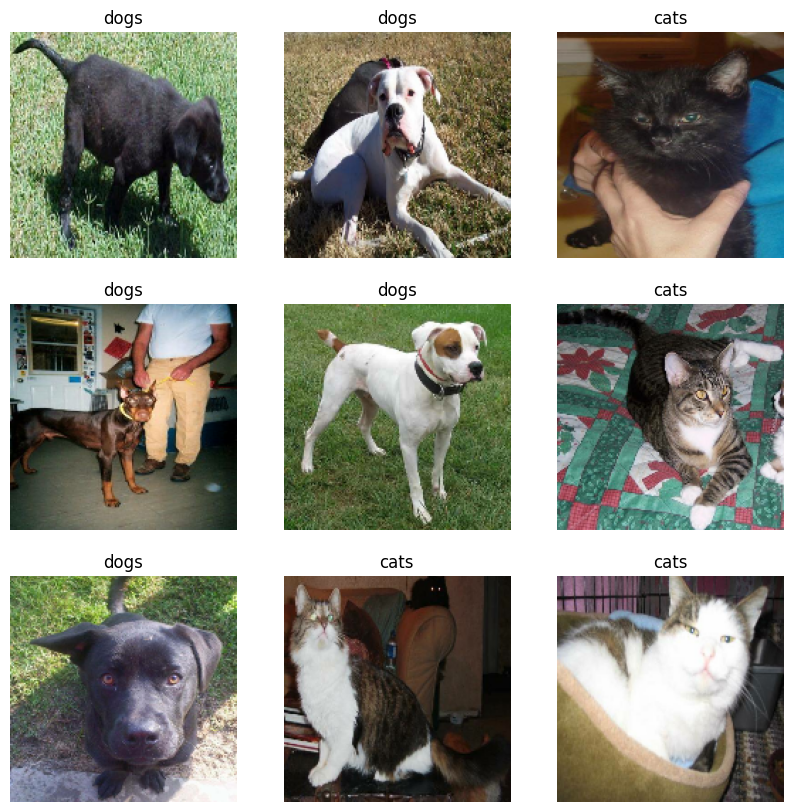

In [17]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [20]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [21]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 21
Number of test batches: 5


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [24]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate`, `Model.predict`, or `Model.call`.

Let's repeatedly apply these layers to the same image and see the result.

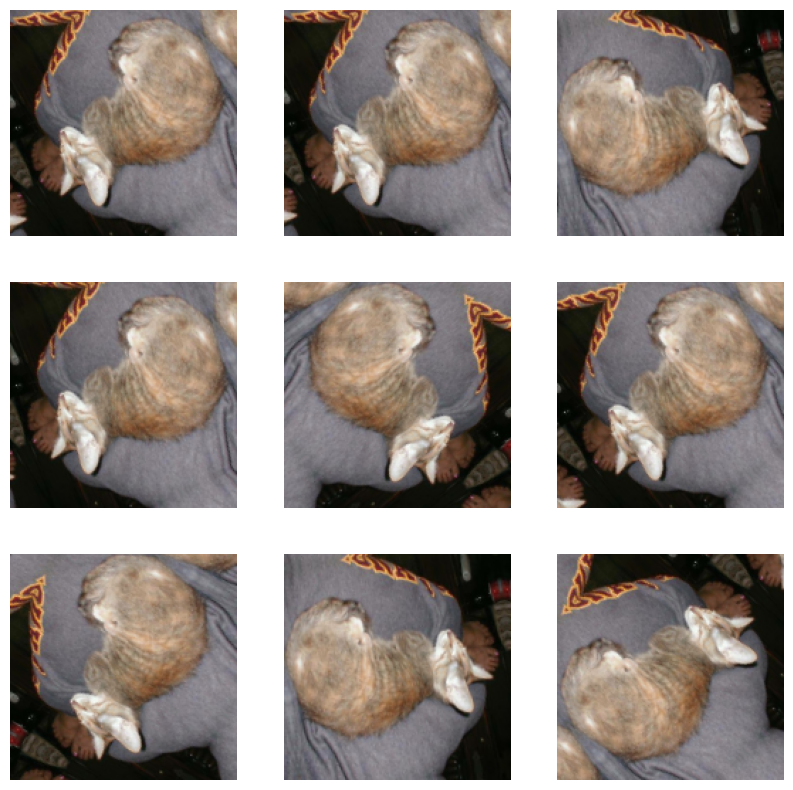

In [25]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [26]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [27]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [30]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [31]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [32]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [33]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [19]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

The 8+ million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [22]:
len(model.trainable_variables)

2

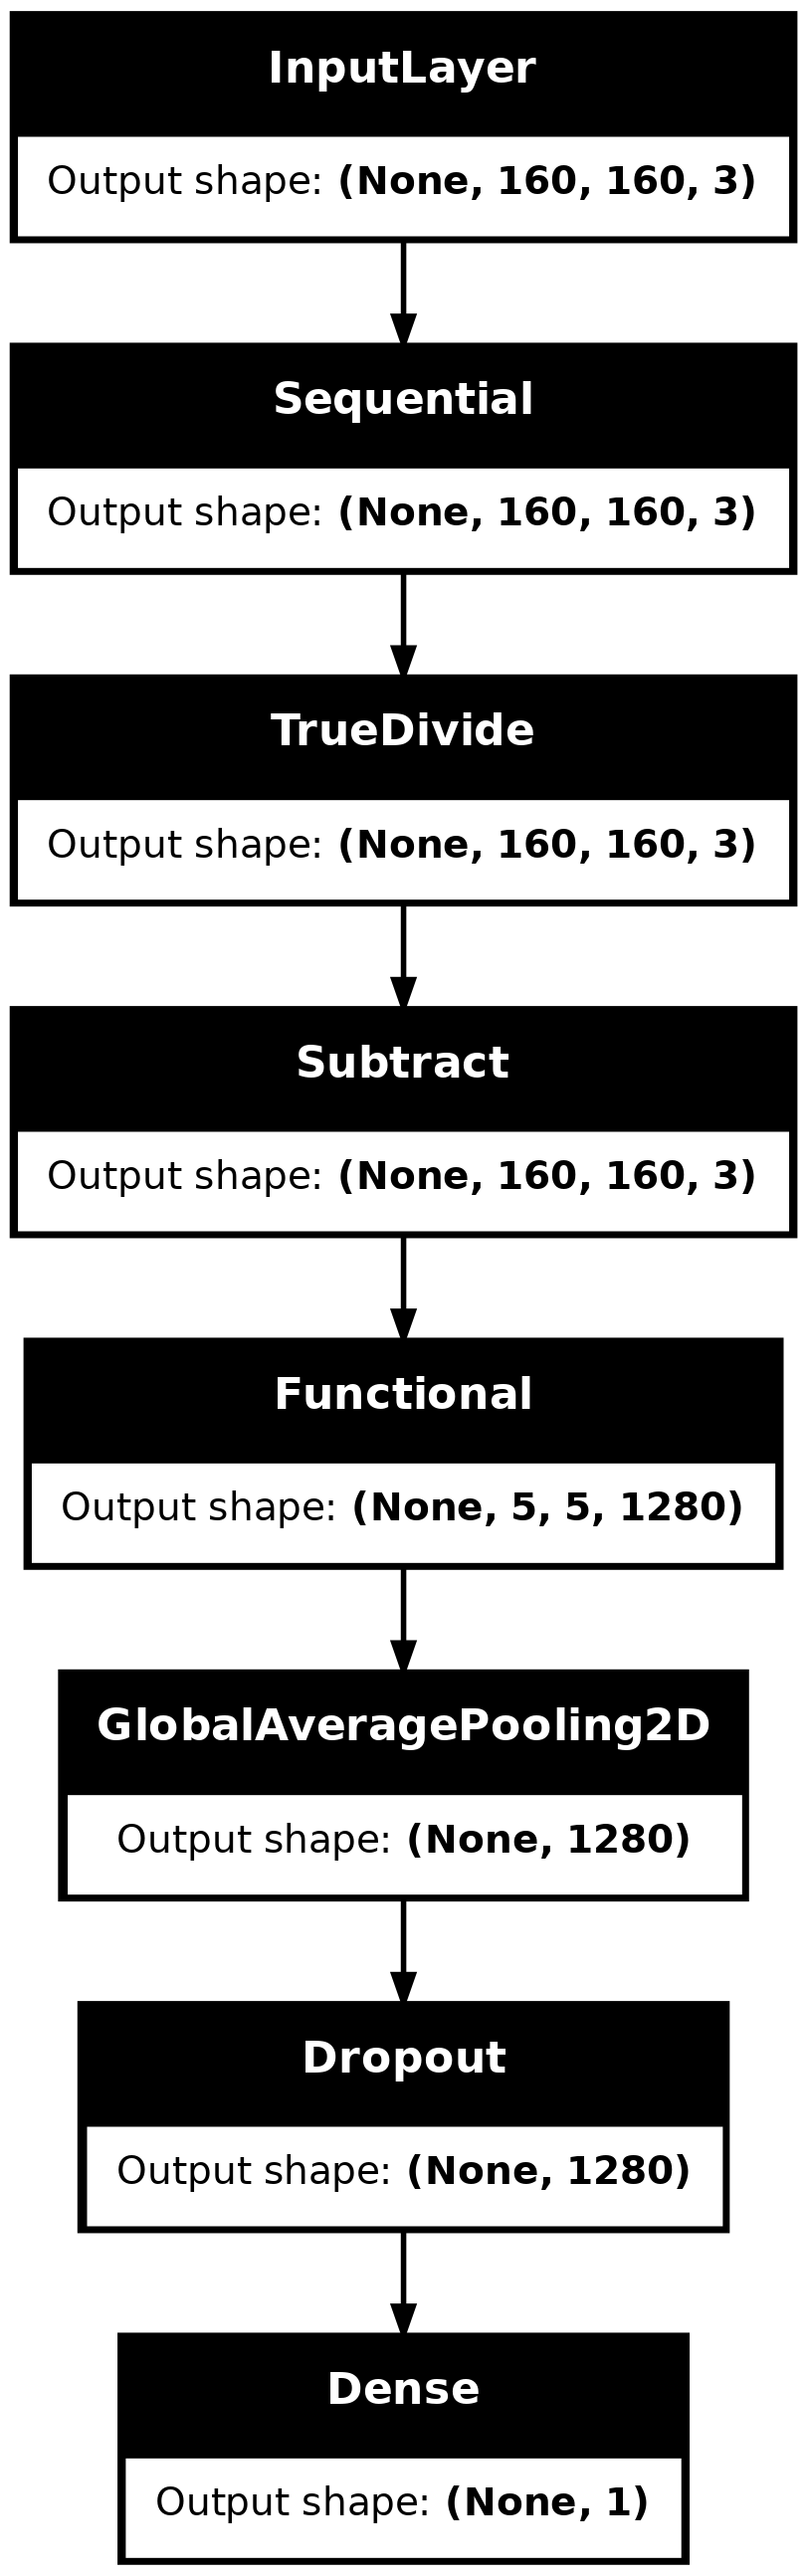

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Compile the model

Compile the model before training it. Since there are two classes and a sigmoid oputput, use the `BinaryAccuracy`.

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

### Train the model

After training for 10 epochs, you should see ~96% accuracy on the validation set.


In [25]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

 1/26 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.6250 - loss: 0.6164

 3/26 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5972 - loss: 0.6475

 5/26 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5927 - loss: 0.6523

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5915 - loss: 0.6572

 9/26 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5908 - loss: 0.6589

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5921 - loss: 0.6597

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5954 - loss: 0.6585

15/26 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5976 - loss: 0.6578

17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6001 - loss: 0.6565

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6020 - loss: 0.6559

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6040 - loss: 0.6552

23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6056 - loss: 0.6550

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6068 - loss: 0.6549

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6072 - loss: 0.6548

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6077 - loss: 0.6547


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.65
initial accuracy: 0.62


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 5:07 5s/step - accuracy: 0.6250 - loss: 0.5902

 3/63 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6684 - loss: 0.6042

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6689 - loss: 0.6300

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6660 - loss: 0.6430

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.6638 - loss: 0.6527

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6624 - loss: 0.6585

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6634 - loss: 0.6599

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6639 - loss: 0.6615

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6633 - loss: 0.6633

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6633 - loss: 0.6639

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6628 - loss: 0.6639

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6623 - loss: 0.6637

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6622 - loss: 0.6634

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6626 - loss: 0.6627

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6635 - loss: 0.6619

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6643 - loss: 0.6609

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6651 - loss: 0.6599

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6659 - loss: 0.6588

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6667 - loss: 0.6576

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6676 - loss: 0.6562

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6684 - loss: 0.6549

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6692 - loss: 0.6534

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6700 - loss: 0.6520

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6707 - loss: 0.6506

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6714 - loss: 0.6491

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6723 - loss: 0.6475

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6730 - loss: 0.6461

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6738 - loss: 0.6445

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6747 - loss: 0.6429

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6755 - loss: 0.6413

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6764 - loss: 0.6397

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6772 - loss: 0.6381

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.6776 - loss: 0.6373 - val_accuracy: 0.8304 - val_loss: 0.4399


Epoch 2/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.7812 - loss: 0.4607

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7483 - loss: 0.4951

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7415 - loss: 0.4977

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7446 - loss: 0.4961

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7454 - loss: 0.4948

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7476 - loss: 0.4941

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7479 - loss: 0.4957

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7494 - loss: 0.4957

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7502 - loss: 0.4952

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7508 - loss: 0.4947

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7509 - loss: 0.4946

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7515 - loss: 0.4940

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7527 - loss: 0.4928

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7541 - loss: 0.4917

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7555 - loss: 0.4907

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7569 - loss: 0.4896

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7582 - loss: 0.4885

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7592 - loss: 0.4875

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7601 - loss: 0.4866

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7609 - loss: 0.4860

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7617 - loss: 0.4853

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7626 - loss: 0.4844

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7635 - loss: 0.4836

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7644 - loss: 0.4829

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7651 - loss: 0.4823

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7656 - loss: 0.4816

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7663 - loss: 0.4809

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7670 - loss: 0.4802

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7676 - loss: 0.4794

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7682 - loss: 0.4788

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7688 - loss: 0.4781

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7697 - loss: 0.4771 - val_accuracy: 0.9035 - val_loss: 0.3350


Epoch 3/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.7812 - loss: 0.4259

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7795 - loss: 0.4515

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7883 - loss: 0.4434

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7890 - loss: 0.4421

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7954 - loss: 0.4384

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8015 - loss: 0.4323

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8067 - loss: 0.4274

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8112 - loss: 0.4227

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8148 - loss: 0.4192

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8173 - loss: 0.4168

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8193 - loss: 0.4153

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8203 - loss: 0.4147

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8215 - loss: 0.4139

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8223 - loss: 0.4137

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8229 - loss: 0.4134

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8236 - loss: 0.4129

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8245 - loss: 0.4123

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8253 - loss: 0.4117

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8261 - loss: 0.4110

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8267 - loss: 0.4104

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8273 - loss: 0.4098

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8278 - loss: 0.4092

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8283 - loss: 0.4086

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8286 - loss: 0.4081

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8289 - loss: 0.4076

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8293 - loss: 0.4070

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8296 - loss: 0.4064

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8301 - loss: 0.4057

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8305 - loss: 0.4050

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8310 - loss: 0.4042

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8314 - loss: 0.4035

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8319 - loss: 0.4024 - val_accuracy: 0.9418 - val_loss: 0.2631


Epoch 4/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.8125 - loss: 0.3533

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8281 - loss: 0.3445

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8425 - loss: 0.3404

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8475 - loss: 0.3428

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8544 - loss: 0.3416

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8600 - loss: 0.3397

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8637 - loss: 0.3376

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8655 - loss: 0.3368

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8673 - loss: 0.3354

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8689 - loss: 0.3339

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8702 - loss: 0.3329

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8713 - loss: 0.3320

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8722 - loss: 0.3311

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8729 - loss: 0.3305

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8734 - loss: 0.3302

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8740 - loss: 0.3297

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8745 - loss: 0.3292

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8749 - loss: 0.3288

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8752 - loss: 0.3284

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8755 - loss: 0.3282

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8758 - loss: 0.3279

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8762 - loss: 0.3275

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8766 - loss: 0.3271

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8769 - loss: 0.3266

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8772 - loss: 0.3262

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8775 - loss: 0.3260

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8777 - loss: 0.3257

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8777 - loss: 0.3255

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8777 - loss: 0.3254

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8776 - loss: 0.3254

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8776 - loss: 0.3254

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8776 - loss: 0.3252 - val_accuracy: 0.9567 - val_loss: 0.2159


Epoch 5/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9062 - loss: 0.2938

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9045 - loss: 0.3070

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9080 - loss: 0.2974

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9096 - loss: 0.2888

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9093 - loss: 0.2868

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9082 - loss: 0.2848

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9075 - loss: 0.2838

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9058 - loss: 0.2842

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9043 - loss: 0.2851

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9028 - loss: 0.2864

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9017 - loss: 0.2867

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9006 - loss: 0.2867

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8997 - loss: 0.2868

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8989 - loss: 0.2869

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8982 - loss: 0.2871

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8977 - loss: 0.2872

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8973 - loss: 0.2873

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8970 - loss: 0.2874

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8966 - loss: 0.2878

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8963 - loss: 0.2880

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8960 - loss: 0.2882

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8959 - loss: 0.2883

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8958 - loss: 0.2883

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8959 - loss: 0.2882

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8958 - loss: 0.2881

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8958 - loss: 0.2881

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8958 - loss: 0.2880

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8958 - loss: 0.2879

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8958 - loss: 0.2879

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8959 - loss: 0.2877

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8960 - loss: 0.2876

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8960 - loss: 0.2874 - val_accuracy: 0.9604 - val_loss: 0.1869


Epoch 6/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.9062 - loss: 0.2619

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8767 - loss: 0.3246

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8798 - loss: 0.3282

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8846 - loss: 0.3198

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8890 - loss: 0.3122

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8919 - loss: 0.3066

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8947 - loss: 0.3023

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8965 - loss: 0.2996

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8983 - loss: 0.2968

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8999 - loss: 0.2943

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9011 - loss: 0.2919

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9023 - loss: 0.2896

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9032 - loss: 0.2878

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9040 - loss: 0.2860

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9045 - loss: 0.2846

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9047 - loss: 0.2837

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9049 - loss: 0.2826

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9052 - loss: 0.2815

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9054 - loss: 0.2804

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9056 - loss: 0.2794

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9059 - loss: 0.2784

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9062 - loss: 0.2775

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9066 - loss: 0.2765

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9071 - loss: 0.2756

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9075 - loss: 0.2747

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9078 - loss: 0.2740

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9080 - loss: 0.2734

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9083 - loss: 0.2728

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9084 - loss: 0.2723

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9085 - loss: 0.2719

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9086 - loss: 0.2714

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9088 - loss: 0.2708 - val_accuracy: 0.9641 - val_loss: 0.1661


Epoch 7/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.9062 - loss: 0.2273

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8924 - loss: 0.2401

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8854 - loss: 0.2539

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8837 - loss: 0.2591

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8842 - loss: 0.2602

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8842 - loss: 0.2606

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8845 - loss: 0.2598

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8849 - loss: 0.2583

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8853 - loss: 0.2580

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8862 - loss: 0.2570

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8872 - loss: 0.2560

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8882 - loss: 0.2550

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8885 - loss: 0.2545

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8887 - loss: 0.2541

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8887 - loss: 0.2536

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8888 - loss: 0.2532

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8888 - loss: 0.2531

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8889 - loss: 0.2530

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8891 - loss: 0.2528

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8893 - loss: 0.2526

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8895 - loss: 0.2524

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8896 - loss: 0.2524

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8899 - loss: 0.2522

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8901 - loss: 0.2521

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8904 - loss: 0.2520

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8907 - loss: 0.2518

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8911 - loss: 0.2514

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8915 - loss: 0.2510

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8919 - loss: 0.2507

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8923 - loss: 0.2505

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8926 - loss: 0.2503

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8931 - loss: 0.2500 - val_accuracy: 0.9629 - val_loss: 0.1517


Epoch 8/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.9062 - loss: 0.2717

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9167 - loss: 0.2490

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9125 - loss: 0.2487

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9100 - loss: 0.2478

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9112 - loss: 0.2447

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9127 - loss: 0.2426

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9140 - loss: 0.2410

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9134 - loss: 0.2414

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9137 - loss: 0.2409

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9140 - loss: 0.2398

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9144 - loss: 0.2390

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9151 - loss: 0.2380

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9157 - loss: 0.2369

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9162 - loss: 0.2360

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9165 - loss: 0.2355

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9166 - loss: 0.2352

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9168 - loss: 0.2348

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9170 - loss: 0.2345

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9171 - loss: 0.2342

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9172 - loss: 0.2340

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9173 - loss: 0.2338

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9174 - loss: 0.2337

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9175 - loss: 0.2334

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9177 - loss: 0.2332

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9177 - loss: 0.2330

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9178 - loss: 0.2327

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9180 - loss: 0.2324

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9182 - loss: 0.2320

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9184 - loss: 0.2316

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9186 - loss: 0.2313

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9187 - loss: 0.2311

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9189 - loss: 0.2309 - val_accuracy: 0.9666 - val_loss: 0.1366


Epoch 9/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9062 - loss: 0.2571

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9045 - loss: 0.2446

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9146 - loss: 0.2300

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9172 - loss: 0.2251

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9177 - loss: 0.2230

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9188 - loss: 0.2206

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9209 - loss: 0.2171

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9220 - loss: 0.2152

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9224 - loss: 0.2137

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9223 - loss: 0.2128

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9225 - loss: 0.2119

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9228 - loss: 0.2111

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9229 - loss: 0.2109

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9229 - loss: 0.2108

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9227 - loss: 0.2109

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9223 - loss: 0.2111

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9217 - loss: 0.2119

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9211 - loss: 0.2127

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9205 - loss: 0.2133

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9201 - loss: 0.2138

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9197 - loss: 0.2141

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9193 - loss: 0.2144

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9190 - loss: 0.2147

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9188 - loss: 0.2149

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9186 - loss: 0.2151

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9184 - loss: 0.2153

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9183 - loss: 0.2156

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9182 - loss: 0.2158

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9182 - loss: 0.2160

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9181 - loss: 0.2162

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9181 - loss: 0.2164

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9181 - loss: 0.2166 - val_accuracy: 0.9715 - val_loss: 0.1270


Epoch 10/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9688 - loss: 0.1742

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9479 - loss: 0.2033

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9397 - loss: 0.2084

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9376 - loss: 0.2101

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9343 - loss: 0.2134

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9332 - loss: 0.2132

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9333 - loss: 0.2122

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9332 - loss: 0.2114

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9328 - loss: 0.2115

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9326 - loss: 0.2116

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9318 - loss: 0.2117

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9308 - loss: 0.2119

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9299 - loss: 0.2126

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9291 - loss: 0.2129

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9284 - loss: 0.2133

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9277 - loss: 0.2135

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9270 - loss: 0.2139

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9264 - loss: 0.2144

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9261 - loss: 0.2146

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9259 - loss: 0.2145

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9257 - loss: 0.2145

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9255 - loss: 0.2144

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9253 - loss: 0.2144

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9252 - loss: 0.2142

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9252 - loss: 0.2140

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9251 - loss: 0.2137

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9252 - loss: 0.2135

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9252 - loss: 0.2132

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9252 - loss: 0.2130

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9252 - loss: 0.2128

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9252 - loss: 0.2126

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9252 - loss: 0.2123 - val_accuracy: 0.9752 - val_loss: 0.1169


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

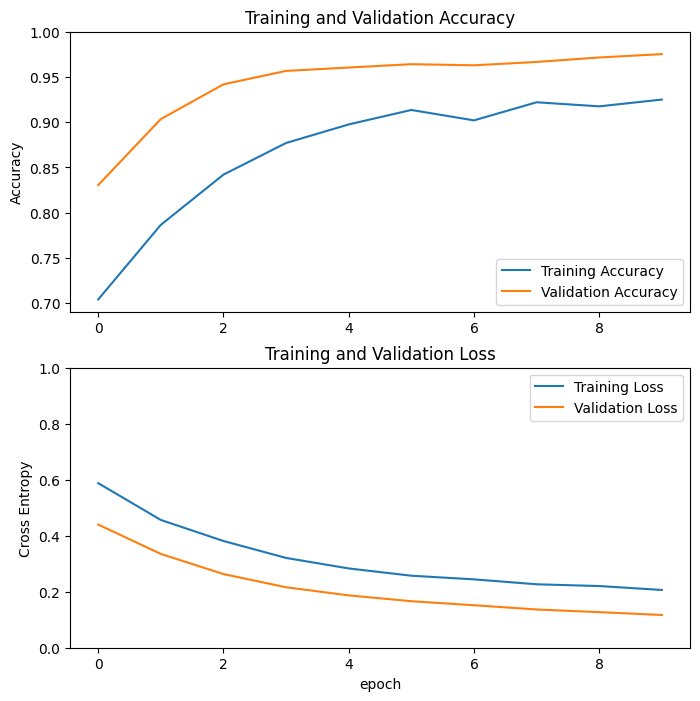

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [29]:
base_model.trainable = True

In [30]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [31]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [32]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [33]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [34]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 9:58 10s/step - accuracy: 0.8438 - loss: 0.3267

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8203 - loss: 0.3535 

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.8142 - loss: 0.3609

 4/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.8099 - loss: 0.3651

 5/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.8042 - loss: 0.3713

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8021 - loss: 0.3779

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8023 - loss: 0.3813

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8045 - loss: 0.3823

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8062 - loss: 0.3835

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8068 - loss: 0.3849

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8076 - loss: 0.3852

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8080 - loss: 0.3864

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8084 - loss: 0.3877

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8090 - loss: 0.3882

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8095 - loss: 0.3885

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8100 - loss: 0.3886

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8101 - loss: 0.3894

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8097 - loss: 0.3907

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8092 - loss: 0.3919

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8088 - loss: 0.3928

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8085 - loss: 0.3935

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8083 - loss: 0.3939

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8080 - loss: 0.3941

24/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8078 - loss: 0.3942

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8076 - loss: 0.3943

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8075 - loss: 0.3944

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8073 - loss: 0.3947

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8072 - loss: 0.3948

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8073 - loss: 0.3947

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8075 - loss: 0.3945

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8077 - loss: 0.3942

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8081 - loss: 0.3937

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8084 - loss: 0.3933

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8088 - loss: 0.3930

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8092 - loss: 0.3926

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8095 - loss: 0.3923

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8098 - loss: 0.3920

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8100 - loss: 0.3919

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8102 - loss: 0.3917

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8103 - loss: 0.3916

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8104 - loss: 0.3915

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8105 - loss: 0.3913

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8107 - loss: 0.3911

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8109 - loss: 0.3908

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8112 - loss: 0.3905

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8114 - loss: 0.3902

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8116 - loss: 0.3899

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8119 - loss: 0.3895

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8122 - loss: 0.3890

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8126 - loss: 0.3886

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8129 - loss: 0.3882

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8132 - loss: 0.3878

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8135 - loss: 0.3874

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8139 - loss: 0.3869

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8142 - loss: 0.3865

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8145 - loss: 0.3860

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8149 - loss: 0.3856

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8152 - loss: 0.3852

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8155 - loss: 0.3847

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8158 - loss: 0.3843

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8161 - loss: 0.3839

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8163 - loss: 0.3836

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8166 - loss: 0.3832

63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.8169 - loss: 0.3828 - val_accuracy: 0.9827 - val_loss: 0.0775


Epoch 12/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.7500 - loss: 0.3702

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7734 - loss: 0.3514

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7969 - loss: 0.3299

 4/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8105 - loss: 0.3185

 5/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8234 - loss: 0.3066

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8303 - loss: 0.2998

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8348 - loss: 0.2975

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8364 - loss: 0.2981

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8380 - loss: 0.2977

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8404 - loss: 0.2958

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8433 - loss: 0.2936

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8457 - loss: 0.2917

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8478 - loss: 0.2902

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8494 - loss: 0.2890

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8511 - loss: 0.2879

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8527 - loss: 0.2868

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8543 - loss: 0.2856

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8553 - loss: 0.2850

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8564 - loss: 0.2845

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8574 - loss: 0.2842

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8583 - loss: 0.2843

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8591 - loss: 0.2842

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8597 - loss: 0.2842

24/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8605 - loss: 0.2840

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8610 - loss: 0.2841

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8614 - loss: 0.2843

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8617 - loss: 0.2844

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8620 - loss: 0.2846

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8623 - loss: 0.2847

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8627 - loss: 0.2846

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8632 - loss: 0.2845

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8636 - loss: 0.2844

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8640 - loss: 0.2843

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8644 - loss: 0.2841

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8648 - loss: 0.2839

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8653 - loss: 0.2836

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8655 - loss: 0.2835

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8659 - loss: 0.2834

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8662 - loss: 0.2832

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8666 - loss: 0.2831

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8669 - loss: 0.2830

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8673 - loss: 0.2828

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8676 - loss: 0.2827

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8680 - loss: 0.2825

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8683 - loss: 0.2823

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8686 - loss: 0.2821

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8689 - loss: 0.2819

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8693 - loss: 0.2817

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8696 - loss: 0.2814

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8699 - loss: 0.2812

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8702 - loss: 0.2810

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8705 - loss: 0.2807

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8708 - loss: 0.2805

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8710 - loss: 0.2803

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8713 - loss: 0.2801

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8715 - loss: 0.2799

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8718 - loss: 0.2797

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8720 - loss: 0.2796

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8722 - loss: 0.2794

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8724 - loss: 0.2792

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8726 - loss: 0.2791

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8727 - loss: 0.2790

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.8731 - loss: 0.2787 - val_accuracy: 0.9827 - val_loss: 0.0679


Epoch 13/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.8438 - loss: 0.2644

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8672 - loss: 0.2314

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8767 - loss: 0.2296

 4/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8861 - loss: 0.2233

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8914 - loss: 0.2195

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8964 - loss: 0.2150

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9004 - loss: 0.2111

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9026 - loss: 0.2094

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9045 - loss: 0.2074

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9060 - loss: 0.2061

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9073 - loss: 0.2048

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9081 - loss: 0.2039

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9088 - loss: 0.2032

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9098 - loss: 0.2024

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9102 - loss: 0.2021

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9107 - loss: 0.2018

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9112 - loss: 0.2013

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9114 - loss: 0.2010

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9112 - loss: 0.2012

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9110 - loss: 0.2014

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9108 - loss: 0.2015

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9106 - loss: 0.2017

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9104 - loss: 0.2020

24/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9102 - loss: 0.2025

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9100 - loss: 0.2029

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9098 - loss: 0.2034

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9096 - loss: 0.2039

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9094 - loss: 0.2042

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9094 - loss: 0.2045

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9094 - loss: 0.2047

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9093 - loss: 0.2051

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9092 - loss: 0.2054

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9092 - loss: 0.2057

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9092 - loss: 0.2059

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9092 - loss: 0.2060

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9092 - loss: 0.2063

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9092 - loss: 0.2064

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9092 - loss: 0.2066

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9093 - loss: 0.2067

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9093 - loss: 0.2068

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9093 - loss: 0.2069

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9093 - loss: 0.2071

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9093 - loss: 0.2071

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9093 - loss: 0.2072

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9094 - loss: 0.2072

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9095 - loss: 0.2072

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9096 - loss: 0.2072

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9097 - loss: 0.2071

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9098 - loss: 0.2070

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9099 - loss: 0.2070

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9101 - loss: 0.2069

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9102 - loss: 0.2069

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9103 - loss: 0.2068

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9104 - loss: 0.2067

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9105 - loss: 0.2067

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9106 - loss: 0.2067

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9106 - loss: 0.2067

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9107 - loss: 0.2067

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9107 - loss: 0.2068

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9108 - loss: 0.2069

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9108 - loss: 0.2070

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9109 - loss: 0.2070

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9109 - loss: 0.2071 - val_accuracy: 0.9851 - val_loss: 0.0598


Epoch 14/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9062 - loss: 0.1674

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9141 - loss: 0.1806

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9219 - loss: 0.1755

 4/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9277 - loss: 0.1722

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9297 - loss: 0.1719

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9319 - loss: 0.1708

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9314 - loss: 0.1717

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9302 - loss: 0.1736

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9299 - loss: 0.1754

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9294 - loss: 0.1766

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9293 - loss: 0.1768

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9278 - loss: 0.1804

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9266 - loss: 0.1832

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9257 - loss: 0.1855

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9247 - loss: 0.1882

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9239 - loss: 0.1902

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9233 - loss: 0.1916

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9230 - loss: 0.1925

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9227 - loss: 0.1936

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9224 - loss: 0.1946

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9222 - loss: 0.1954

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9221 - loss: 0.1960

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9220 - loss: 0.1964

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9220 - loss: 0.1968

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9220 - loss: 0.1971

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9220 - loss: 0.1973

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9220 - loss: 0.1975

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9219 - loss: 0.1977

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9219 - loss: 0.1978

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9219 - loss: 0.1979

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9220 - loss: 0.1979

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9220 - loss: 0.1979

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9220 - loss: 0.1979

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9221 - loss: 0.1978

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9222 - loss: 0.1977

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9223 - loss: 0.1975

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9224 - loss: 0.1973

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9226 - loss: 0.1971

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9227 - loss: 0.1969

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9229 - loss: 0.1967

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9231 - loss: 0.1965

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9232 - loss: 0.1963

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9234 - loss: 0.1962

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9235 - loss: 0.1960

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9237 - loss: 0.1959

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9239 - loss: 0.1957

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9241 - loss: 0.1955

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9242 - loss: 0.1953

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9244 - loss: 0.1952

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9245 - loss: 0.1951

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9246 - loss: 0.1949

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9247 - loss: 0.1948

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9247 - loss: 0.1947

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9248 - loss: 0.1945

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9249 - loss: 0.1943

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9250 - loss: 0.1942

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9251 - loss: 0.1939

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9252 - loss: 0.1938

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9253 - loss: 0.1936

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9254 - loss: 0.1933

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9256 - loss: 0.1930 - val_accuracy: 0.9889 - val_loss: 0.0481


Epoch 15/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9375 - loss: 0.1260

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9375 - loss: 0.1394

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9375 - loss: 0.1496

 4/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9395 - loss: 0.1554

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9428 - loss: 0.1559

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9428 - loss: 0.1584

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9433 - loss: 0.1590

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9436 - loss: 0.1593

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9433 - loss: 0.1595

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9427 - loss: 0.1607

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9427 - loss: 0.1612

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9425 - loss: 0.1616

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9423 - loss: 0.1619

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9418 - loss: 0.1623

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9417 - loss: 0.1623

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9412 - loss: 0.1628

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9405 - loss: 0.1633

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9401 - loss: 0.1637

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9397 - loss: 0.1640

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9393 - loss: 0.1644

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9389 - loss: 0.1649

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9385 - loss: 0.1653

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9382 - loss: 0.1655

24/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9381 - loss: 0.1656

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9379 - loss: 0.1657

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9378 - loss: 0.1657

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9378 - loss: 0.1656

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9379 - loss: 0.1655

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9380 - loss: 0.1652

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9381 - loss: 0.1650

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9383 - loss: 0.1648

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9384 - loss: 0.1646

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9386 - loss: 0.1644

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9387 - loss: 0.1642

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9388 - loss: 0.1641

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9390 - loss: 0.1640

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9391 - loss: 0.1640

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9392 - loss: 0.1640

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9392 - loss: 0.1640

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9393 - loss: 0.1640

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9394 - loss: 0.1639

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9395 - loss: 0.1638

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9396 - loss: 0.1638

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9397 - loss: 0.1637

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9398 - loss: 0.1636

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9399 - loss: 0.1635

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9400 - loss: 0.1634

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9401 - loss: 0.1634

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9401 - loss: 0.1634

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9402 - loss: 0.1633

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9402 - loss: 0.1633

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9402 - loss: 0.1632

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9402 - loss: 0.1632

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9402 - loss: 0.1632

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9402 - loss: 0.1632

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9402 - loss: 0.1632

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9402 - loss: 0.1631

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9403 - loss: 0.1631

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9403 - loss: 0.1631

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9403 - loss: 0.1630

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9403 - loss: 0.1630

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9403 - loss: 0.1629

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9403 - loss: 0.1629 - val_accuracy: 0.9889 - val_loss: 0.0462


Epoch 16/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 1.0000 - loss: 0.0627

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9844 - loss: 0.0871

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9757 - loss: 0.1023

 4/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9720 - loss: 0.1094

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9639 - loss: 0.1186

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9586 - loss: 0.1259

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9549 - loss: 0.1310

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9518 - loss: 0.1349

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9494 - loss: 0.1385

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9476 - loss: 0.1410

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9451 - loss: 0.1443

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9434 - loss: 0.1469

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9422 - loss: 0.1484

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9412 - loss: 0.1500

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9404 - loss: 0.1515

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9396 - loss: 0.1527

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9387 - loss: 0.1543

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9378 - loss: 0.1557

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9372 - loss: 0.1567

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9367 - loss: 0.1577

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9364 - loss: 0.1583

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9361 - loss: 0.1589

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9358 - loss: 0.1594

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9355 - loss: 0.1598

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9351 - loss: 0.1602

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9347 - loss: 0.1605

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9345 - loss: 0.1607

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9342 - loss: 0.1608

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9341 - loss: 0.1609

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9340 - loss: 0.1608

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9339 - loss: 0.1608

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9338 - loss: 0.1607

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9338 - loss: 0.1607

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9337 - loss: 0.1607

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9336 - loss: 0.1608

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9335 - loss: 0.1607

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9334 - loss: 0.1609

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9334 - loss: 0.1609

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9333 - loss: 0.1610

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9333 - loss: 0.1611

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9333 - loss: 0.1612

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9333 - loss: 0.1612

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9333 - loss: 0.1613

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9332 - loss: 0.1614

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9332 - loss: 0.1614

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9332 - loss: 0.1614

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9332 - loss: 0.1614

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9332 - loss: 0.1613

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9332 - loss: 0.1613

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9332 - loss: 0.1613

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9332 - loss: 0.1612

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9333 - loss: 0.1611

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9333 - loss: 0.1611

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9334 - loss: 0.1609

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9334 - loss: 0.1608

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9335 - loss: 0.1607

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9335 - loss: 0.1607

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9336 - loss: 0.1606

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9336 - loss: 0.1605

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9336 - loss: 0.1605

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9337 - loss: 0.1603

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9338 - loss: 0.1602 - val_accuracy: 0.9889 - val_loss: 0.0377


Epoch 17/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.9375 - loss: 0.1182

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9297 - loss: 0.1342

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9253 - loss: 0.1453

 4/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9245 - loss: 0.1505

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9246 - loss: 0.1521

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9259 - loss: 0.1524

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9269 - loss: 0.1533

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9287 - loss: 0.1524

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9305 - loss: 0.1512

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9312 - loss: 0.1506

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9317 - loss: 0.1498

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9327 - loss: 0.1487

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9332 - loss: 0.1482

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9335 - loss: 0.1483

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9341 - loss: 0.1480

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9345 - loss: 0.1475

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9347 - loss: 0.1476

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9348 - loss: 0.1475

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9351 - loss: 0.1473

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9352 - loss: 0.1472

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9354 - loss: 0.1471

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9355 - loss: 0.1469

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9355 - loss: 0.1471

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9356 - loss: 0.1471

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9357 - loss: 0.1470

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9359 - loss: 0.1468

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9360 - loss: 0.1465

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9362 - loss: 0.1463

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9362 - loss: 0.1462

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9364 - loss: 0.1461

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9365 - loss: 0.1460

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9366 - loss: 0.1459

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9367 - loss: 0.1458

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9367 - loss: 0.1457

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9368 - loss: 0.1456

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9369 - loss: 0.1455

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9370 - loss: 0.1454

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9371 - loss: 0.1451

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9373 - loss: 0.1449

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9375 - loss: 0.1446

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9377 - loss: 0.1443

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9378 - loss: 0.1441

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9380 - loss: 0.1438

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9382 - loss: 0.1436

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9383 - loss: 0.1434

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9384 - loss: 0.1432

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9386 - loss: 0.1430

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9387 - loss: 0.1428

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9388 - loss: 0.1427

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9389 - loss: 0.1425

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9390 - loss: 0.1424

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9391 - loss: 0.1423

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9391 - loss: 0.1422

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9392 - loss: 0.1422

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9392 - loss: 0.1421

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9393 - loss: 0.1420

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9394 - loss: 0.1420

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9395 - loss: 0.1419

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9395 - loss: 0.1419

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9396 - loss: 0.1418

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9397 - loss: 0.1418

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9398 - loss: 0.1417

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9399 - loss: 0.1416 - val_accuracy: 0.9876 - val_loss: 0.0382


Epoch 18/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.9688 - loss: 0.0877

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9688 - loss: 0.0926

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9722 - loss: 0.0920

 4/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9714 - loss: 0.0979

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9696 - loss: 0.1013

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9686 - loss: 0.1030

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9673 - loss: 0.1050

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9660 - loss: 0.1063

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9652 - loss: 0.1074

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9630 - loss: 0.1100

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9612 - loss: 0.1127

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9599 - loss: 0.1145

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9587 - loss: 0.1159

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9579 - loss: 0.1169

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9569 - loss: 0.1181

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9562 - loss: 0.1191

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9556 - loss: 0.1199

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9553 - loss: 0.1202

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9550 - loss: 0.1205

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9544 - loss: 0.1215

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9540 - loss: 0.1223

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9536 - loss: 0.1229

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9532 - loss: 0.1237

24/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9529 - loss: 0.1243

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9527 - loss: 0.1248

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9524 - loss: 0.1253

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9522 - loss: 0.1258

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9519 - loss: 0.1263

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9518 - loss: 0.1268

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9517 - loss: 0.1271

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9516 - loss: 0.1274

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9516 - loss: 0.1276

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9515 - loss: 0.1279

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9514 - loss: 0.1281

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9513 - loss: 0.1283

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9513 - loss: 0.1286

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9512 - loss: 0.1287

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9512 - loss: 0.1289

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9511 - loss: 0.1292

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9510 - loss: 0.1294

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9510 - loss: 0.1297

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9509 - loss: 0.1299

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9508 - loss: 0.1301

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9507 - loss: 0.1304

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9507 - loss: 0.1306

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9507 - loss: 0.1307

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9506 - loss: 0.1309

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9506 - loss: 0.1310

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9506 - loss: 0.1311

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9506 - loss: 0.1312

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9506 - loss: 0.1313

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9505 - loss: 0.1315

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9505 - loss: 0.1316

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9504 - loss: 0.1318

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9503 - loss: 0.1319

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9503 - loss: 0.1321

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9502 - loss: 0.1322

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9502 - loss: 0.1324

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9501 - loss: 0.1325

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9501 - loss: 0.1327

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9500 - loss: 0.1328

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9500 - loss: 0.1330

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9499 - loss: 0.1333 - val_accuracy: 0.9864 - val_loss: 0.0402


Epoch 19/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 1.0000 - loss: 0.0656

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9844 - loss: 0.0936

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9722 - loss: 0.1213

 4/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9655 - loss: 0.1350

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9624 - loss: 0.1395

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9582 - loss: 0.1433

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9553 - loss: 0.1456

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9526 - loss: 0.1478

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9509 - loss: 0.1487

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9499 - loss: 0.1488

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9493 - loss: 0.1487

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9487 - loss: 0.1482

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9484 - loss: 0.1475

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9483 - loss: 0.1466

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9481 - loss: 0.1460

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9477 - loss: 0.1458

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9474 - loss: 0.1454

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9472 - loss: 0.1449

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9471 - loss: 0.1444

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9468 - loss: 0.1442

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9466 - loss: 0.1440

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9465 - loss: 0.1437

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9464 - loss: 0.1434

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9464 - loss: 0.1430

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9464 - loss: 0.1427

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9464 - loss: 0.1423

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9464 - loss: 0.1419

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9463 - loss: 0.1420

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9461 - loss: 0.1421

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9460 - loss: 0.1422

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9458 - loss: 0.1423

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9457 - loss: 0.1423

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9457 - loss: 0.1422

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9457 - loss: 0.1421

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9457 - loss: 0.1420

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9457 - loss: 0.1418

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9458 - loss: 0.1417

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9459 - loss: 0.1416

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9459 - loss: 0.1416

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9459 - loss: 0.1415

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9460 - loss: 0.1415

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9460 - loss: 0.1414

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9460 - loss: 0.1414

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9460 - loss: 0.1413

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9460 - loss: 0.1412

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9461 - loss: 0.1410

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9462 - loss: 0.1408

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9462 - loss: 0.1407

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9462 - loss: 0.1406

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9462 - loss: 0.1405

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9463 - loss: 0.1404

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9463 - loss: 0.1402

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9464 - loss: 0.1401

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9464 - loss: 0.1399

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9465 - loss: 0.1397

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9466 - loss: 0.1395

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9467 - loss: 0.1393

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9467 - loss: 0.1391

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9468 - loss: 0.1390

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9469 - loss: 0.1388

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9469 - loss: 0.1386

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9470 - loss: 0.1385

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9471 - loss: 0.1381 - val_accuracy: 0.9827 - val_loss: 0.0410


Epoch 20/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9688 - loss: 0.0653

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9688 - loss: 0.0669

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9688 - loss: 0.0762

 4/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9668 - loss: 0.0834

 5/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9659 - loss: 0.0876

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9638 - loss: 0.0946

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9632 - loss: 0.0988

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9634 - loss: 0.1009

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9636 - loss: 0.1021

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9642 - loss: 0.1026

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9643 - loss: 0.1030

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9638 - loss: 0.1039

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9633 - loss: 0.1050

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9621 - loss: 0.1067

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9611 - loss: 0.1080

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9604 - loss: 0.1089

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9598 - loss: 0.1097

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9593 - loss: 0.1103

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9590 - loss: 0.1108

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9588 - loss: 0.1111

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9587 - loss: 0.1112

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9587 - loss: 0.1112

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9587 - loss: 0.1113

24/63 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9586 - loss: 0.1114

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9586 - loss: 0.1115

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9586 - loss: 0.1114

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9585 - loss: 0.1115

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9585 - loss: 0.1115

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9584 - loss: 0.1117

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9582 - loss: 0.1121

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9580 - loss: 0.1126

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9578 - loss: 0.1131

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9575 - loss: 0.1137

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9571 - loss: 0.1143

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9569 - loss: 0.1148

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9566 - loss: 0.1152

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9565 - loss: 0.1156

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9563 - loss: 0.1159

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9561 - loss: 0.1162

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9559 - loss: 0.1165

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9558 - loss: 0.1167

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9557 - loss: 0.1168

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9556 - loss: 0.1169

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9555 - loss: 0.1171

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9555 - loss: 0.1173

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9554 - loss: 0.1174

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9554 - loss: 0.1175

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9553 - loss: 0.1176

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9553 - loss: 0.1177

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9552 - loss: 0.1178

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9552 - loss: 0.1180

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9551 - loss: 0.1181

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9550 - loss: 0.1183

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9550 - loss: 0.1184

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9550 - loss: 0.1186

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9549 - loss: 0.1187

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9549 - loss: 0.1188

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9549 - loss: 0.1188

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9548 - loss: 0.1189

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9548 - loss: 0.1190

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9548 - loss: 0.1191

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9547 - loss: 0.1191

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9546 - loss: 0.1193 - val_accuracy: 0.9851 - val_loss: 0.0368


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

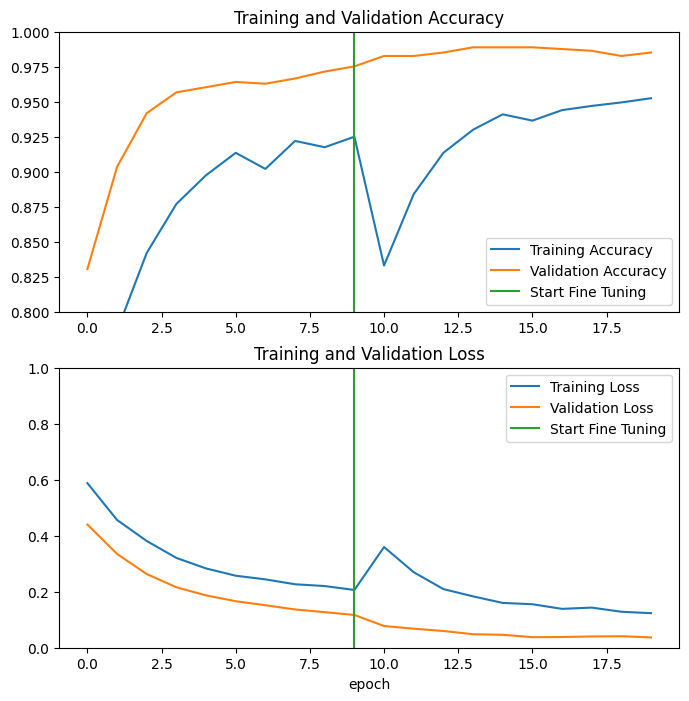

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [37]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9688 - loss: 0.1283

3/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9809 - loss: 0.0892

5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9857 - loss: 0.0723

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9853 - loss: 0.0681


Test accuracy : 0.984375


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 0 1 0 0]


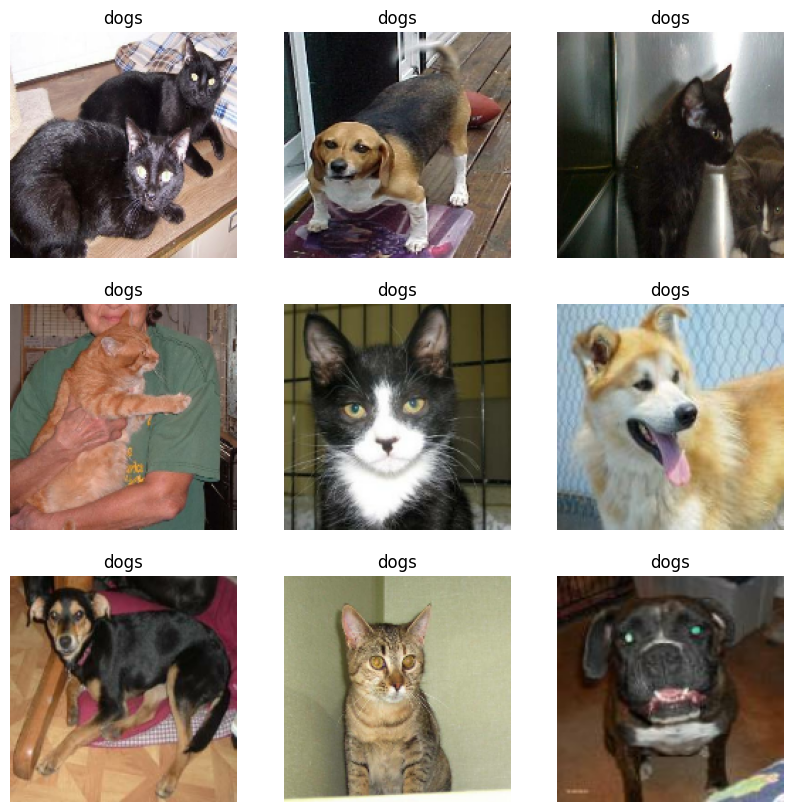

In [38]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
